In [1]:
from concurrent.futures import ProcessPoolExecutor

from extra_data import open_run

from hed_6659.visar import VISAR, VISAR_DEVICES

In [2]:
proposal_number = 6656
run_number = 22
calibration_file = "./visar_calibration_values.toml"

run = open_run(proposal_number, run_number)

In [3]:
kepler1 = VISAR(run, "KEPLER1", config_file=calibration_file)

In [4]:
# print run information
kepler1.info()

KEPLER1 properties for p006656, r0022:
  Difference X-drive: 8.41752 ns
  Etalon thickness:   17.18 mm
  Motor displacement: 5.41857 mm
  Sensitivity:        2900.39 m/s
  Sweep delay:        0.898077 
  Sweep time:         20 ns
  Temporal delay:     0.08889 ns
  Zero delay:         8.71734 mm

  Train ID (shots): [2084617140]
  Train ID (ref.): [2084617000]

DiPOLE properties for p006656, r0022:
  Delay:  -10 ns
  Energy: 20.683 J


In [5]:
# compute read all required data from files and corrects the detector image
kepler1.compute()

# explore data
kepler1.dataset

<xarray.Dataset> Size: 67MB
Dimensions:             (trainId: 2, dim_0: 4096, dim_1: 4096, Space: 4096,
                         Time: 4096)
Coordinates:
  * trainId             (trainId) uint64 16B 2084617000 2084617140
    type                (trainId) <U9 72B 'reference' 'shot'
Dimensions without coordinates: dim_0, dim_1, Space, Time
Data variables:
    Etalon thickness    (trainId) float64 16B 17.18 17.18
    Sweep time          int64 8B 20
    Sweep delay         (trainId) float64 16B 0.8981 0.8981
    Difference X-drive  (trainId) float64 16B 8.418 8.418
    Motor displacement  (trainId) float64 16B 5.419 5.419
    Sensitivity         (trainId) float64 16B 2.9e+03 2.9e+03
    Temporal delay      (trainId) float64 16B 0.08889 0.08889
    Zero delay          (trainId) float64 16B 8.717 8.717
    image               (trainId, dim_0, dim_1) uint16 67MB 0 0 0 0 ... 0 0 0 0
    Space axis          (trainId, Space) float64 66kB -1.024e+03 ... 1.024e+03
    Time axis           (trainId, Time) float64 66kB -1.386 -1.381 ... 22.36

In [6]:
# and dipole settings
kepler1.dipole.compute()

kepler1.dipole.dataset

<xarray.Dataset> Size: 2kB
Dimensions:    (trainId: 2, time [ns]: 98)
Coordinates:
  * trainId    (trainId) uint64 16B 2084617000 2084617140
    type       (trainId) <U9 72B 'reference' 'shot'
  * time [ns]  (time [ns]) float64 784B -5.0 -4.8 -4.6 -4.4 ... 14.0 14.2 14.4
Data variables:
    Delay      (trainId) float64 16B -10.0 -10.0
    Energy     (trainId) float64 16B 33.49 20.68
    Trace      (trainId, time [ns]) float64 2kB nan nan nan ... 0.0 3.25e+06

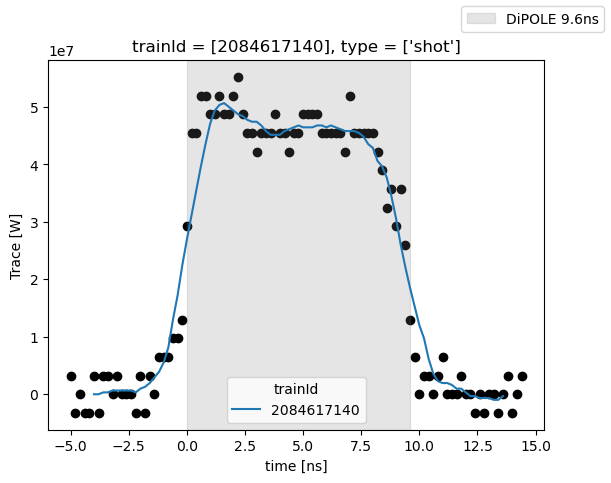

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

trace = kepler1.dipole.trace()
trace = trace[trace.type == 'shot']
trace.plot.scatter(x='time [ns]', y='trace', color='k', ax=ax)
trace.rolling(dim={'time [ns]': 10}, center=True).mean().plot.line(hue='trainId', ax=ax)

max_duration = max(trace.attrs['durations'])
ax.axvspan(0, max_duration, color='gray', alpha=0.2, label=f'DiPOLE {round(max_duration, 2)}ns')
_ = fig.legend()

# Process / save data

In [8]:
# Save data to an HDF5 file, in netCDF format
kepler1.to_h5()

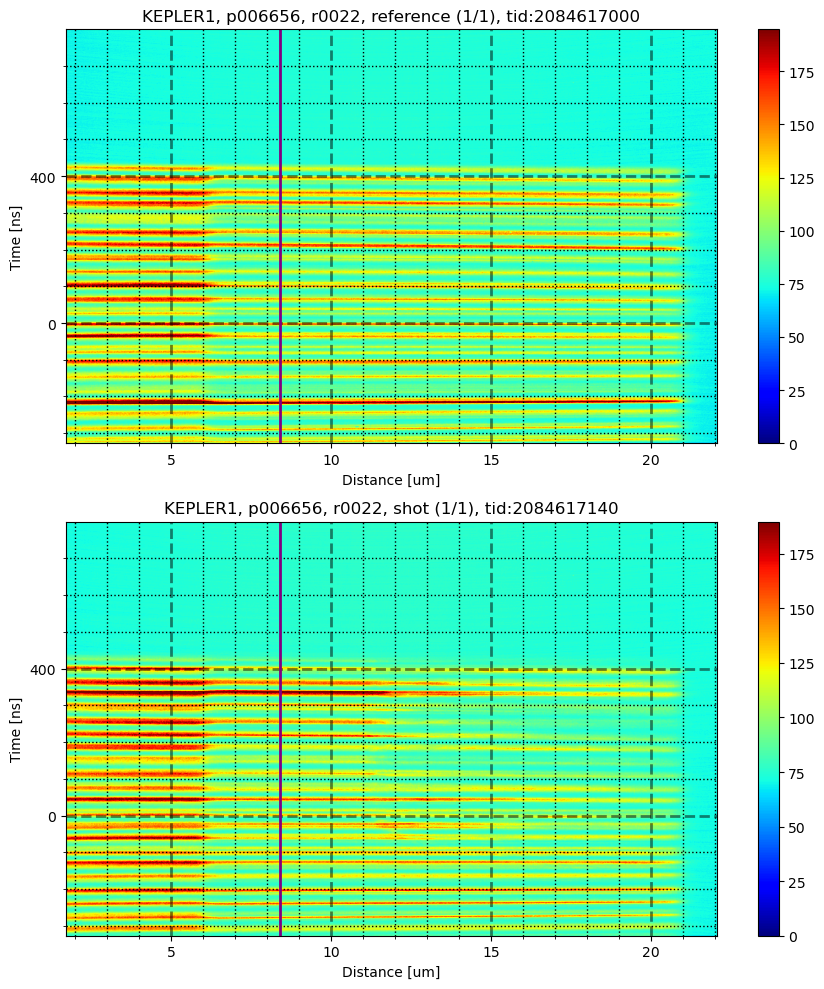

In [9]:
# save plots as png
kepler1.to_png()

# Example: process all imagers

- Correct all images
- save results in HDF5 file
- save plots as png

In [10]:
%%time

def _work(visar):
    r = open_run(proposal_number, run_number)
    v = VISAR(r, visar, config_file=calibration_file)
    v.compute()
    v.to_png()
    return v

with ProcessPoolExecutor(max_workers=len(VISAR_DEVICES)) as pool:
    for vis in pool.map(_work, VISAR_DEVICES):
        print(vis.name)
        vis.to_h5()


KEPLER1
KEPLER2
VISAR_1w
SOP
CPU times: user 2 s, sys: 810 ms, total: 2.81 s
Wall time: 5.71 s
